In [1]:
import numpy as np
import pandas as pd
from numba import njit

from math import log, sqrt, pi, exp
from scipy.stats import norm

from matplotlib import pyplot as plt
from tqdm import tqdm
from time import perf_counter
import gc

# Binomial Tree

In [2]:
def buildTree(S, vol , T, N, r):
    dt = T / N
    matrix = np.zeros((N + 1, N + 1))
    prob_matrix = np.zeros((N + 1, N + 1))  ;   prob_matrix[0,0] = 1
    u = np.e **  (vol * np.sqrt(dt)) # TODO
    d = np.e ** (-vol * np.sqrt(dt)) # TODO
    p = (np.exp(r*dt) - d)/(u - d) # TODO

    # Iterate over the lower triangle
    for i in np.arange(N + 1): # iterate over rows
        for j in np.arange(i + 1): # iterate over columns
            # Hint: express each cell as a combination of up and down moves
            matrix[i, j] = S * d ** (i-j) * u ** (j)

    # Iterate over the lower triangle
    for i in np.arange(1, N + 1): # iterate over rows
        for j in np.arange(i + 1): # iterate over columns
            # Hint: express each cell as a combination of up and down moves
            prob_matrix[i, j] = prob_matrix[i-1, j]*(1-p) + prob_matrix[i-1, j-1]*p

    return matrix, prob_matrix

Visualisation 2 Shape = (11, 1)


,Probabilities 1Y,Probabilities 0.5Y
S Value,,
36,1.042276e-20,NaN
37,7.210140e-19,NaN
38,2.452311e-17,NaN
39,5.466284e-16,NaN
40,8.980839e-15,NaN
...,...,...
156,1.470383e-11,NaN
160,1.189667e-12,NaN
164,7.094612e-14,NaN


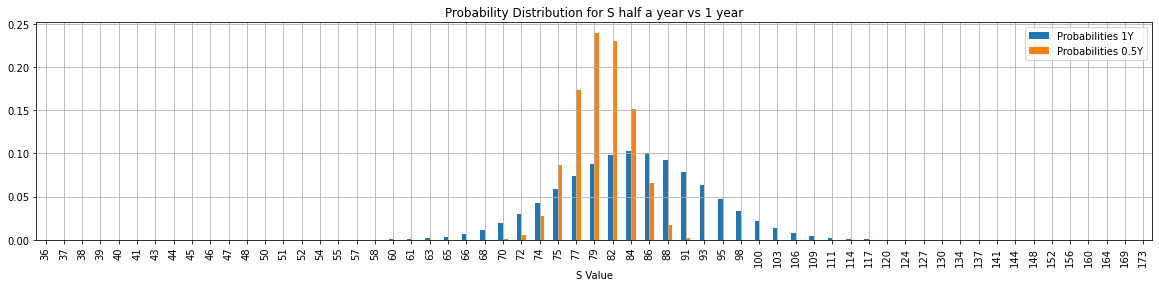

In [3]:
sigma = 0.1
S = 80
T =1.
N = 60
r = 0.06

tree, prob_tree = buildTree(S, sigma, T, N, r)

visualisation = pd.DataFrame()
visualisation['S Value'] = tree[-1,:].astype(int)
visualisation['Probabilities'] = prob_tree[-1,:]
visualisation.set_index('S Value', inplace=True)
# visualisation.plot.bar('Values', 'Probabilities', figsize=(20,4))
# print(visualisation)

visualisation_2 = pd.DataFrame() # prob_tree.take([25,-1],axis=0)).T
visualisation_2['S Value'] = tree[10,:].astype(int)
visualisation_2['Probabilities'] = prob_tree[10,:]
visualisation_2 = visualisation_2[visualisation_2['S Value'] > 0]
visualisation_2.set_index('S Value', inplace=True)
print(f'Visualisation 2 Shape = {visualisation_2.shape}')

visualisation_3 = visualisation.join(visualisation_2, lsuffix=' 1Y', rsuffix=' 0.5Y', how='outer')
# visualisation_3 = visualisation_3[visualisation_3['Probabilities 1Y'] > 0.000001]
visualisation_3.plot(kind='bar', figsize=(20,4), grid=True, title="Probability Distribution for S half a year vs 1 year")
visualisation_3
# visualisation_2.plot.bar('Values', 'Probabilities', figsize=(20,4))

## Full Binomial Tree

In [4]:
@njit
def call_bt(T, r, K, vol, N, S):
    dt = T / N
    u = np.exp(vol * np.sqrt(dt))
    d = np.exp(-vol * np.sqrt(dt))
    p = (np.exp(r*dt) - d)/(u - d)
    
    """ ----- Build the Tree ----- """
    tree = np.zeros((N + 1, N + 1))
    # Iterate over the lower triangle
    for i in np.arange(N + 1): # iterate over rows
        for j in np.arange(i + 1): # iterate over columns
            # Hint: express each cell as a combination of up and down moves
            tree[i, j] = S * d ** (i-j) * u ** (j) # TODO

    """ ----- Calculate the Option Value ----- """
    columns = tree.shape[1]
    rows = tree.shape[0]

    # Walk backward , we start in last row of the matrix

    # Add the payoff function in the last row
    for c in np.arange(columns):
        _S = tree[rows-1, c] # value in the matrix
        tree[rows-1, c] = max(0, _S - K)

    # For all other rows , we need to combine from previous rows
    # We walk backwards , from the last row to the first row
    for i in np.arange(rows-1)[::-1]:
        for j in np.arange(i + 1):
            down = tree[i+1, j]
            up = tree[i + 1, j + 1]
            tree[i , j ] = (np.exp(-r*dt)) * (p * up + (1 - p) * down)
    V = tree[0,0]
    
    """ Greeks """
    D = (tree[1, 1] - tree[1, 0])/(S * (u - d))
    return V, D

In [ ]:
sigma = 0.2
S = 100
T=1.
N=10_000

K = 99
r = 0.06

# tree = buildTree(S, sigma, T, N)
V_bt, D_bt = call_bt(T, r , K, sigma, N, S)
print(f'Option Value with N({N}) steps = {V_bt:.5f}')
print(f'Delta with N({N}) steps        = {D_bt:.5f}')
# option_value_tree

# Black-Scholes Formula

In [5]:
def bs_call(S, K, T, r, sigma):
    d1 = (log(S/K)+(r+sigma**2/2.)*T)/(sigma*sqrt(T))
    d2 = d1 - sigma*sqrt(T)

    V = S*norm.cdf(d1) -K*exp(-r*T)*norm.cdf(d2)
    D = norm.cdf(d1)

    return V, D

In [8]:
sigma = 0.2
S = 100
T=1.

K = 99
r = 0.06
bs_result, bs_D = bs_call(S,K,T,r,sigma)
print(f'Option Value with Black-Scholes Formula = {bs_result}')
print(f'Delta Value with Black-Scholes Formula = {bs_D}')

Option Value with Black-Scholes Formula = 11.544280227051097
Delta Value with Black-Scholes Formula = 0.6737355117348961


# Tests
## Option Value Convergence with n

In [153]:

T=1.
r = 0.06
K = 99
sigma = 0.2
S = 100

NN = np.log2(10_000) ;   size = 50   ;
values = np.zeros((size, 3))
for n in tqdm(np.append(np.logspace(1, NN, size, base=2, dtype=int), 50)): #  _starting_n, NN)):
    # print(n)
    _st = perf_counter()
    V_bt, _ = call_bt(T, r, K, sigma, n, S)
    values[size-1] = [n, V_bt, perf_counter() - _st]
    size -= 1
values = values[::-1]

100%|███████████████████████████████████████████| 51/51 [00:17<00:00,  2.93it/s]


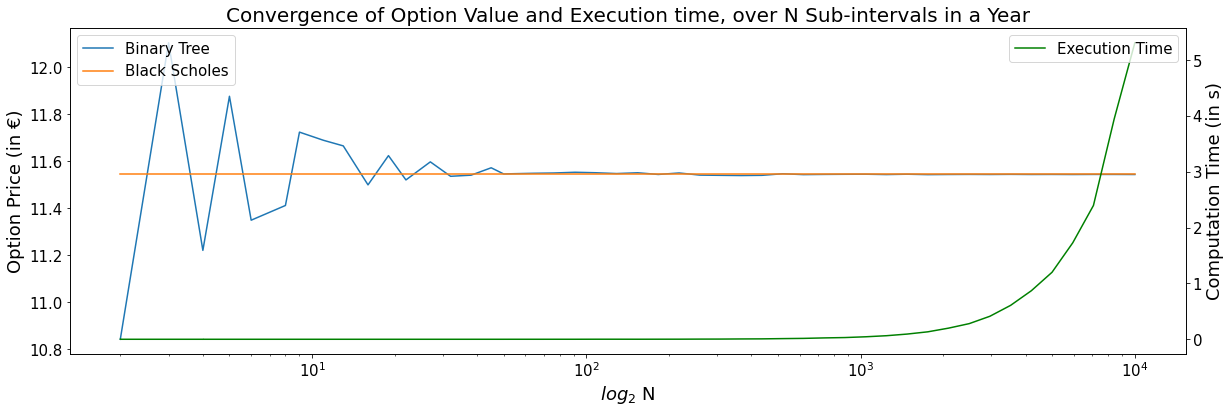

In [205]:
_results_df = pd.DataFrame(values[:, 1:], columns=['Binary_Tree', 'Execution_Time'] , index=values[:, 0]).sort_index()
_results_df["Black_Scholes"] = bs_result
# _results_df

fig, ax_left = plt.subplots()
ax_right = ax_left.twinx()

# Plot Results
_results_df.Binary_Tree.plot(figsize=(20,6), ax=ax_left, logx=True, fontsize=15)
_results_df.Black_Scholes.plot(ax=ax_left, logx=True)
_results_df.Execution_Time.plot(ax=ax_right, logx=True, color='green', fontsize=15)

# Make readable
ax_left.legend(['Binary Tree', 'Black Scholes'], loc = 2, fontsize = 15)
ax_left.set_ylabel('Option Price (in €)', fontsize = 18)
ax_right.legend(['Execution Time'], loc = 1, fontsize = 15)
ax_right.set_ylabel('Computation Time (in s)', fontsize = 18)
ax_left.set_xlabel(r"$log_2$ N", fontsize = 18)
plt.title('Convergence of Option Value and Execution time, over N Sub-intervals in a Year', fontsize = 20)

# print(f'Option Value with N({int(2**NN)}) = {_results_df.iloc[-1].Binary_Tree:.5f} EUR')
# print(f'Option Value with N(50)   = {_results_df[_results_df.index == 50.0].Binary_Tree.values[0]:.5f} EUR')
# print(f'Difference with ({int(2**NN)})    = {_results_df.iloc[-1].Binary_Tree - _results_df[_results_df.index == 50.0].Binary_Tree.values[0]:.5f} EUR')
# print(f'Option Value Black-Scholes Formula = {_results_df.iloc[-1].Black_Scholes:.5f} EUR')
# # print(f'% Difference = {(_results_df.iloc[-1].Option_Value - _results_df[_results_df.index == 50.0].Option_Value.values[0]) / _results_df[_results_df.index == 50.0].Option_Value.values[0] * 100}')

plt.show(fig)

## Option Value accuracy for different Levels of Volatility

In [100]:
V_df = np.zeros((100,0))
D_df = np.zeros((100,0))
Inx_df = np.zeros((50,0))

_S = 100    ; _T = 1.   ; _K = 99   ; _r = 0.06

volatility = [10., 5., 1., .5, .1, .05]
for inx, vol in enumerate(volatility):
    V_bs, D_bs = bs_call(_S, _K, _T, _r, vol)

    _N = np.log2(100) ;   size = 100
    values = np.zeros((size, 3))
    for n in range(1, 100): #tqdm(np.append(np.logspace(1, _N, size, base=2, dtype=int), 50)): #  _starting_n, NN)):
        V_bt, D_bt = call_bt(_T, _r, _K, vol, n, _S)

        V_diff = (V_bt - V_bs)/V_bs * 100
        D_diff = (D_bt - D_bs)/D_bs * 100

        values[size-1] = [n, V_diff, D_diff]    ;   size -= 1
    # values = values[::-1]

    V_df = (np.insert(V_df, inx, values[:,1], axis=1))
    D_df = (np.insert(D_df, inx, values[:,2], axis=1))

columns = [f'σ = {v}' for v in volatility]
V_df = pd.DataFrame(V_df, index=values[:,0], columns=columns).drop_duplicates().sort_index()
D_df = pd.DataFrame(D_df, index=values[:,0], columns=columns).drop_duplicates().sort_index()
V_df
# values_df.sort_index(inplace=True)
# values_df

,σ = 10.0,σ = 5.0,σ = 1.0,σ = 0.5,σ = 0.1,σ = 0.05
0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1.0,-0.008714,-0.094945,18.764541,19.713060,4.389356,-8.098810
2.0,-0.163003,-4.294319,-9.853122,-8.649692,-4.017578,-2.060112
3.0,-0.005498,-0.364255,6.490177,6.718843,2.014428,-0.590886
4.0,-0.025652,-1.975455,-5.081738,-4.340992,-1.657787,-0.921635
...,...,...,...,...,...,...
95.0,-0.000033,-0.023931,0.197652,0.192118,-0.120373,-0.008694
96.0,-0.000044,-0.067744,-0.155621,-0.069924,0.064792,-0.058287
97.0,-0.000032,-0.023448,0.193485,0.187811,-0.121915,-0.008335
98.0,-0.000043,-0.066330,-0.151662,-0.067130,0.063603,-0.059398


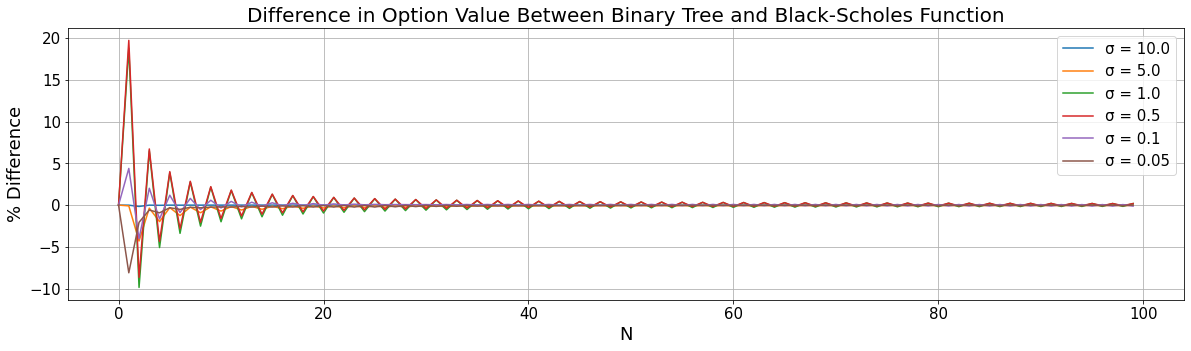

In [110]:
V_df.plot(figsize=(20,5), legend='Option Value - USD', grid=True, logx=False, fontsize=15)
plt.xlabel('N', fontsize=18)
plt.ylabel('% Difference', fontsize=18)
plt.title('Difference in Option Value Between Binary Tree and Black-Scholes Function', fontsize=20)
plt.legend(fontsize = 15)
#inx = [50.0]
# values_df[values_df.where(values_df.index == 50.0)]
# values_df[(values_df.index == 50.0)]

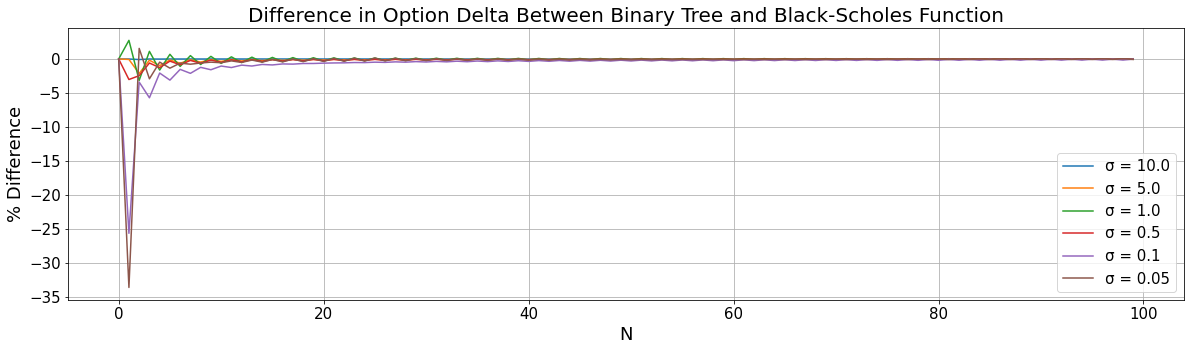

In [111]:
D_df.plot(figsize=(20,5), legend='Option Value - USD', grid=True, logx=False, fontsize=15)
plt.xlabel('N', fontsize=18)
plt.ylabel('% Difference', fontsize=18)
plt.title('Difference in Option Delta Between Binary Tree and Black-Scholes Function', fontsize=20)
plt.legend(fontsize = 15)

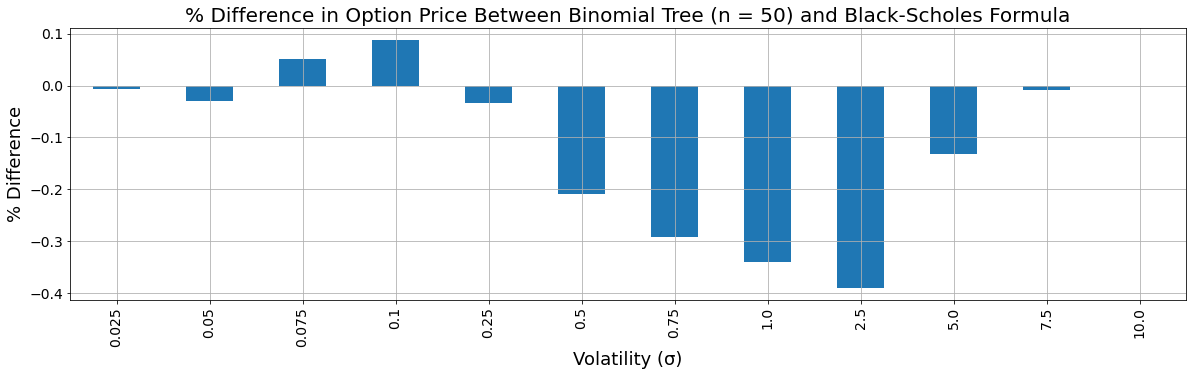

In [150]:
values_df = pd.DataFrame()
_S = 100    ;    _T=1. ; _K = 99   ;   _r = 0.06

space = []
for fp in [10, 1, .1, .01]:
    _divisions = 4
    for sd in [(x+1)/_divisions for x in range(_divisions)]:
        space.append(fp*sd)
# print(space)

N = 50 ;   size = len(space)-4
values = np.zeros((size, 2))
for vol in space[:-4]:
    V_bt, D_bt = call_bt(_T, _r, _K, vol, N, _S)
    V_bs, D_bs = bs_call(_S, _K, _T, _r, vol)
    values[size-1] = [f"{vol:.3f}", ((V_bt - V_bs)/V_bs)*100]
    size -= 1

# pd.set_eng_float_format(accuracy=3)
values = pd.DataFrame(values[::-1][:,1], index=values[::-1][:,0], columns=['% Difference'])
values.sort_index(inplace=True)
values.plot(kind='bar', figsize=(20,5), grid=True, legend=False, fontsize = 14)
plt.title("% Difference in Option Price Between Binomial Tree (n = 50) and Black-Scholes Formula", fontsize = 20)
plt.ylabel('% Difference', fontsize = 18)
plt.xlabel('Volatility (σ)', fontsize = 18)
plt.show()
# values

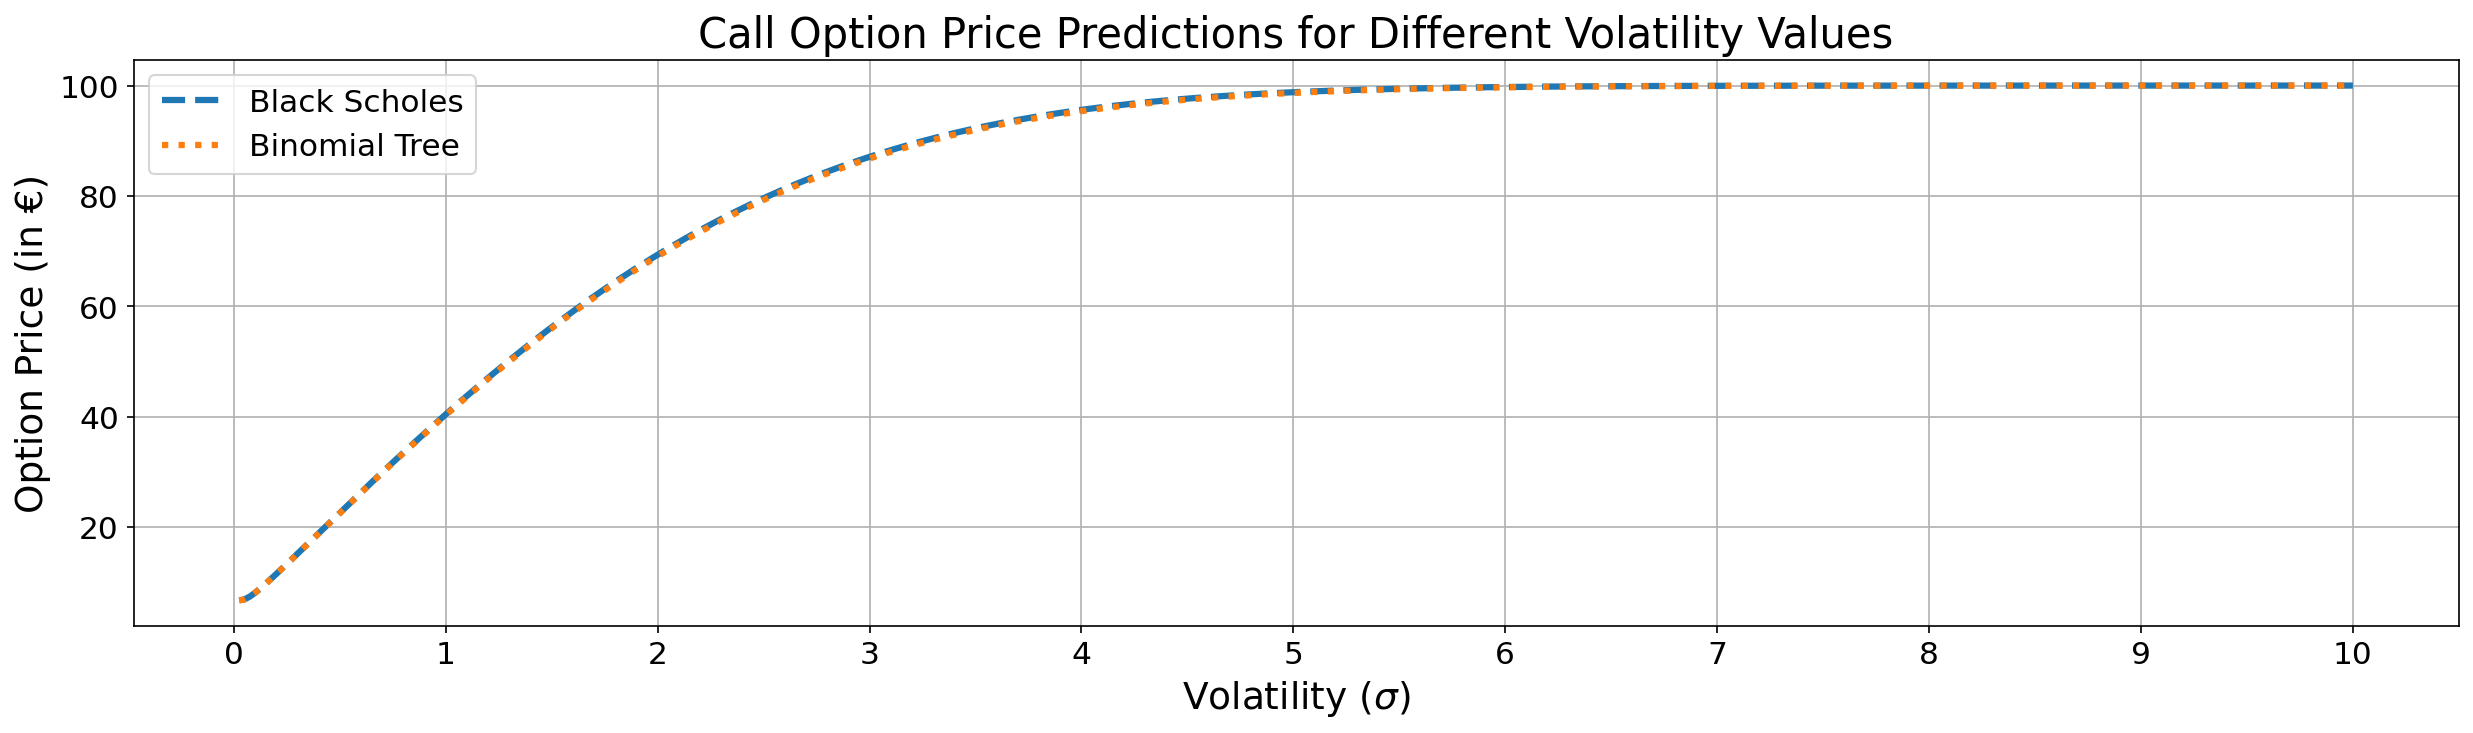

In [106]:
# Experimenting with different volatility values for the Binomial Tree
BS_values = []; tree_values = []
S = 100
T = 1.
K = 99
r = 0.06
N = 50

vol = np.linspace(0.025, 10, num=399)
for sigma in vol:
    bt_value, bt_delta = call_bt(T, r, K, sigma, N, S)
    tree_values.append(bt_value)
    
    bs_value, bs_delta = bs_call(S, K, T, r, sigma)
    BS_values.append(bs_value)

# Make figure
plt.figure(figsize=(20,5), dpi=150)
plt.plot(vol, BS_values, linestyle="dashed", label="Black Scholes", linewidth = 3)
plt.plot(vol, tree_values, linestyle="dotted", label="Binomial Tree", linewidth = 3)
plt.xlabel(r"Volatility ($\sigma$)", fontsize = 18)
plt.ylabel(r"Option Price (in €)", fontsize = 18)
plt.legend(fontsize = 15)
plt.title("Call Option Price Predictions for Different Volatility Values", fontsize = 20)
plt.xticks(np.arange(0, 10.1, 1), fontsize = 15)
plt.yticks(fontsize = 15)
plt.grid()
plt.show()

Text(0.5, 0, 'Volatility (σ)')

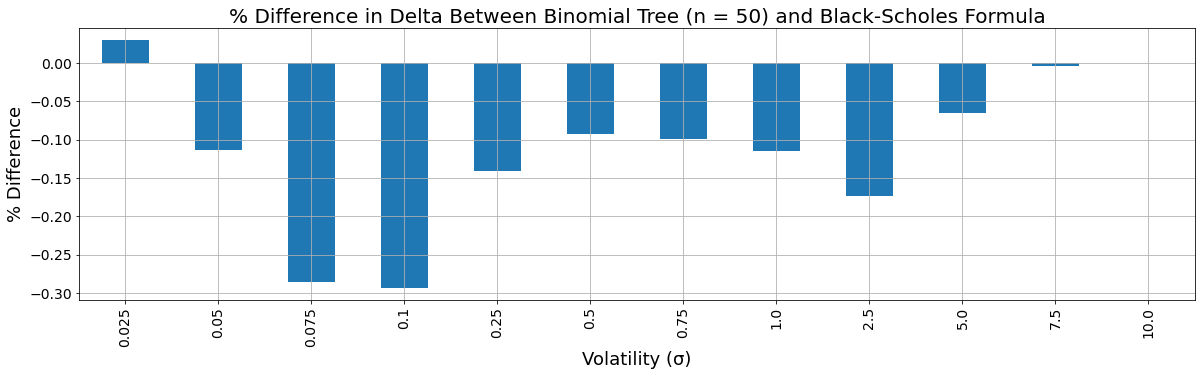

In [116]:
values_df = pd.DataFrame()
_S = 100    ;    _T = 1. ; _K = 99   ;   _r = 0.06

space = []
for fp in [10, 1, .1, .01]:
    _divisions = 4
    for sd in [(x+1)/_divisions for x in range(_divisions)]:
        space.append(fp*sd)
# print(space)

N = 50 ;   size = len(space)-4
values = np.zeros((size, 2))
for vol in space[:-4]:
    V_bt, D_bt = call_bt(_T, _r, _K, vol, N, _S)
    V_bs, D_bs = bs_call(_S, _K, _T, _r, vol)
    values[size-1] = [f"{vol:.3f}", (D_bt - D_bs)/D_bs*100]
    size -= 1

# pd.set_eng_float_format(accuracy=3)
values = pd.DataFrame(values[::-1][:,1], index=values[::-1][:,0], columns=['% Difference'])
values.sort_index(inplace=True)
values.plot(kind='bar', figsize=(20,5), grid=True, legend=False, fontsize = 14)
plt.title("% Difference in Delta Between Binomial Tree (n = 50) and Black-Scholes Formula", fontsize = 20)
plt.ylabel('% Difference', fontsize = 18)
plt.xlabel('Volatility (σ)', fontsize = 18)
plt.show()
# values

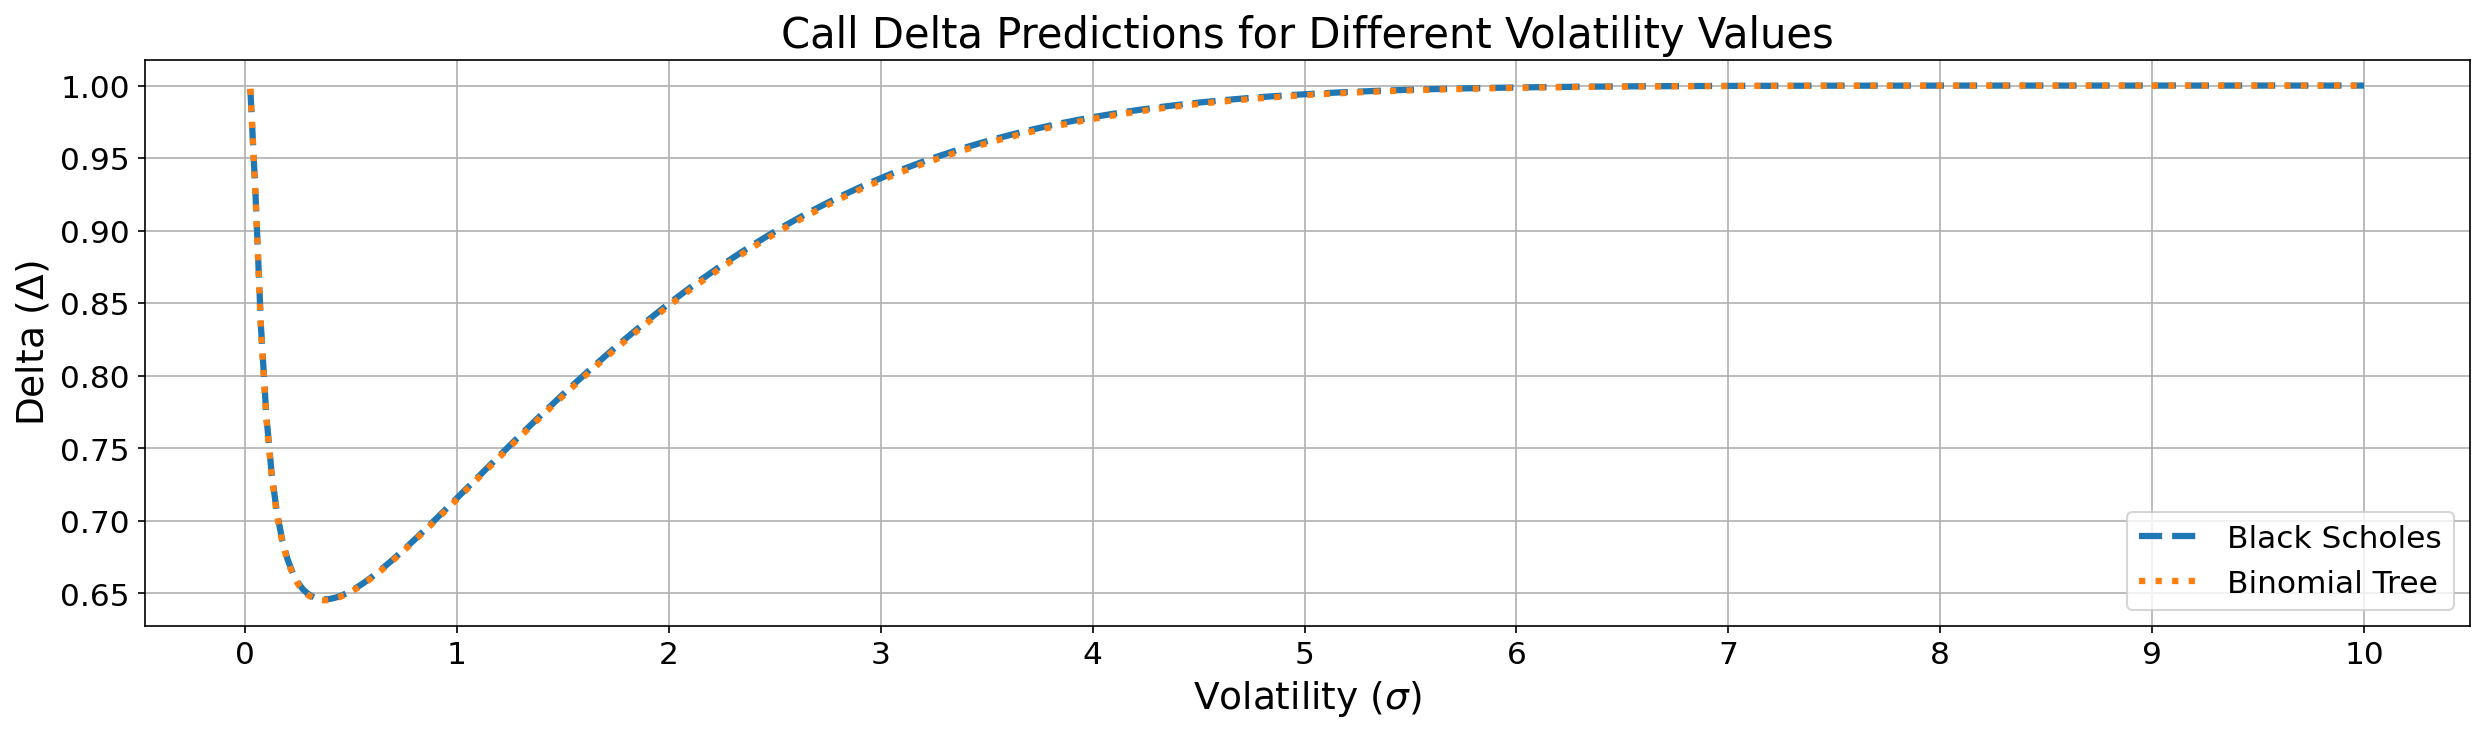

In [104]:
# Experimenting with different volatility values for the Binomial Tree
BS_deltas = []; tree_deltas = []
S = 100
T = 1.
K = 99
r = 0.06
N = 50

vol = np.linspace(0.025, 10, num=399)
for sigma in vol:
    optionPrice, delta_tree = call_bt(T, r , K, sigma, N, S)
    tree_deltas.append(delta_tree)

    d1 = (np.log(S/K) + (r + 1/2 * sigma ** 2) * T)/(sigma * np.sqrt(T))
    delta_BS = norm.cdf(d1)
    BS_deltas.append(delta_BS)

# Make figure
plt.figure(figsize=(20,5), dpi=150)
plt.plot(vol, BS_deltas, linestyle="dashed", label="Black Scholes", linewidth = 3)
plt.plot(vol, tree_deltas, linestyle="dotted", label="Binomial Tree", linewidth = 3)
plt.xlabel(r"Volatility ($\sigma$)", fontsize = 18)
plt.ylabel(r"Delta ($\Delta$)", fontsize = 18)
plt.legend(fontsize = 15)
plt.title("Call Delta Predictions for Different Volatility Values", fontsize = 20)
plt.xticks(np.arange(0, 10.1, 1), fontsize = 15)
plt.yticks(fontsize = 15)
plt.grid()
plt.show()

--------------------------------------------------------------------------------------------------------------------------------------------
# American options

In [74]:
@njit
def option_contract_bt(T, r , K, vol, N, S, type="C", american=False):
    dt = T / N
    u = np.exp(vol * np.sqrt(dt))
    d = np.exp(-vol * np.sqrt(dt))
    p = (np.exp(r*dt) - d)/(u - d)
    """ ----- Build the Tree ----- """
    tree = np.zeros((N + 1, N + 1))
    # Iterate over the lower triangle
    for i in np.arange(N + 1): # iterate over rows
        for j in np.arange(i + 1): # iterate over columns
            tree[i, j] = S * d ** (i-j) * u ** (j)

    """ ----- Calculate the Option Value ----- """
    columns = tree.shape[1]
    rows = tree.shape[0]

    # Walk backward, we start in last row of the matrix

    # Add the payoff function in the last row
    for c in np.arange(columns):
        _S = tree[rows-1, c] # value in the matrix
        if type == "C": tree[rows - 1, c] = max(0, _S - K)
        else: tree[rows - 1, c] = max(0, K - _S)
    # print( tree.astype(int) )

    # For all other rows , we need to combine from previous rows
    # We walk backwards , from the last row to the first row
    for i in np.arange(rows-1)[::-1]:
        for j in np.arange(i + 1):
            down = tree[i+1, j]
            up = tree[i + 1, j + 1]
            if type == "C":
                if american:    tree[i, j] = max(tree[i, j]-K, (np.exp(-r*dt)) * (p * up + (1 - p) * down)) # TODO
                else:   tree[i, j] = (np.exp(-r*dt)) * (p * up + (1 - p) * down) # TODO
            else:
                if american:    tree[i, j] = max(K-tree[i, j], (np.exp(-r * dt)) * (p * up + (1 - p) * down)) # TODO
                else:   tree[i, j] = (np.exp(-r*dt)) * (p * up + (1 - p) * down) # TODO

    V = tree[0, 0]
    """ Greeks """
    D = (tree[1, 1] - tree[1, 0])/(S * (u - d))
    return V, D

In [75]:
sigma = 0.2
S = 100
T=1.
N=5

K = 99
r = 0.06

V_bt, D_bt = option_contract_bt(T, r, K, sigma, N, S, type="C", american=True)
print(f'Option Value with N({N}) steps = {V_bt:.5f}')
print(f'Delta with N({N}) steps        = {D_bt:.5f}')

Option Value with N(5) steps = 11.87716
Delta with N(5) steps        = 0.65949


## Difference between European and American Options for different levels of volatility

100%|███████████████████████████████████████████| 12/12 [00:01<00:00, 11.48it/s]


\begin{tabular}{lrrr}
\toprule
{} &  American &  European &  \% Difference \\
\midrule
0.025  &   0.02701 &   0.00180 &    1396.99448 \\
0.050  &   0.41627 &   0.17639 &     135.99121 \\
0.075  &   1.07552 &   0.68244 &      57.59994 \\
0.100  &   1.85049 &   1.37793 &      34.29472 \\
0.250  &   7.18674 &   6.60304 &       8.83981 \\
0.500  &  16.51082 &  15.87699 &       3.99212 \\
0.750  &  25.67885 &  24.98169 &       2.79067 \\
1.000  &  34.47351 &  33.69776 &       2.30210 \\
2.500  &  74.30509 &  72.82528 &       2.03200 \\
5.000  &  95.10695 &  92.02959 &       3.34388 \\
7.500  &  97.48155 &  93.21726 &       4.57457 \\
10.000 &  98.07811 &  93.23463 &       5.19494 \\
\bottomrule
\end{tabular}



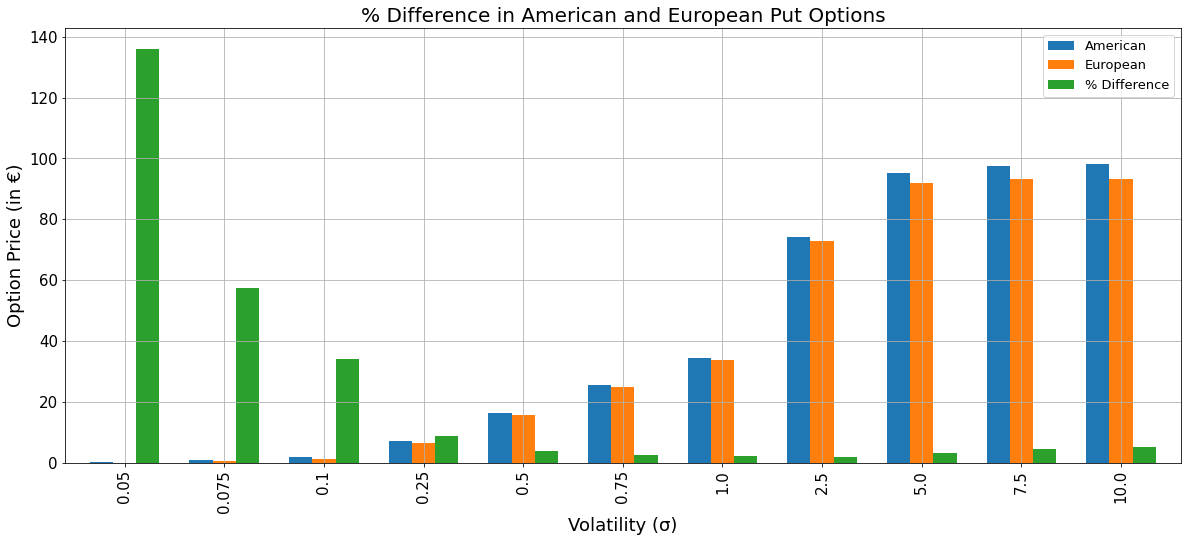

In [133]:
values_df = pd.DataFrame()
_S = 100    ;    _T = 1. ; _K = 99   ;   _r = 0.06

space = []
for fp in [10, 1, .1]:
    _divisions = 4
    for sd in [(x+1)/_divisions for x in range(_divisions)]:
        space.append(fp*sd)

N = 1_000 ;   size = len(space)
values = np.zeros((size, 4))
for vol in tqdm(space):
    american_put_option_value, _ = option_contract_bt(T, r , K, vol, N, S, type="P", american=True)
    european_put_option_value, _ = option_contract_bt(T, r , K, vol, N, S, type="P", american=False)
    values[size-1] = [f"{vol:.3f}", american_put_option_value, european_put_option_value, (american_put_option_value - european_put_option_value)/european_put_option_value*100]
    size -= 1

values = pd.DataFrame(values[::-1][:,1:], index=values[::-1][:,0], columns=['American','European', '% Difference'])
values.sort_index(inplace=True, ascending=True)
values.iloc[1:,:].plot(kind='bar', figsize=(20,8), grid=True, legend=True, fontsize = 15, width = 0.7)
plt.title("% Difference in American and European Put Options", fontsize = 20)
plt.ylabel('Option Price (in €)', fontsize = 18)
plt.xlabel('Volatility (σ)', fontsize = 18)
plt.legend(fontsize = 13)

print(values.to_latex(float_format='%.5f'))

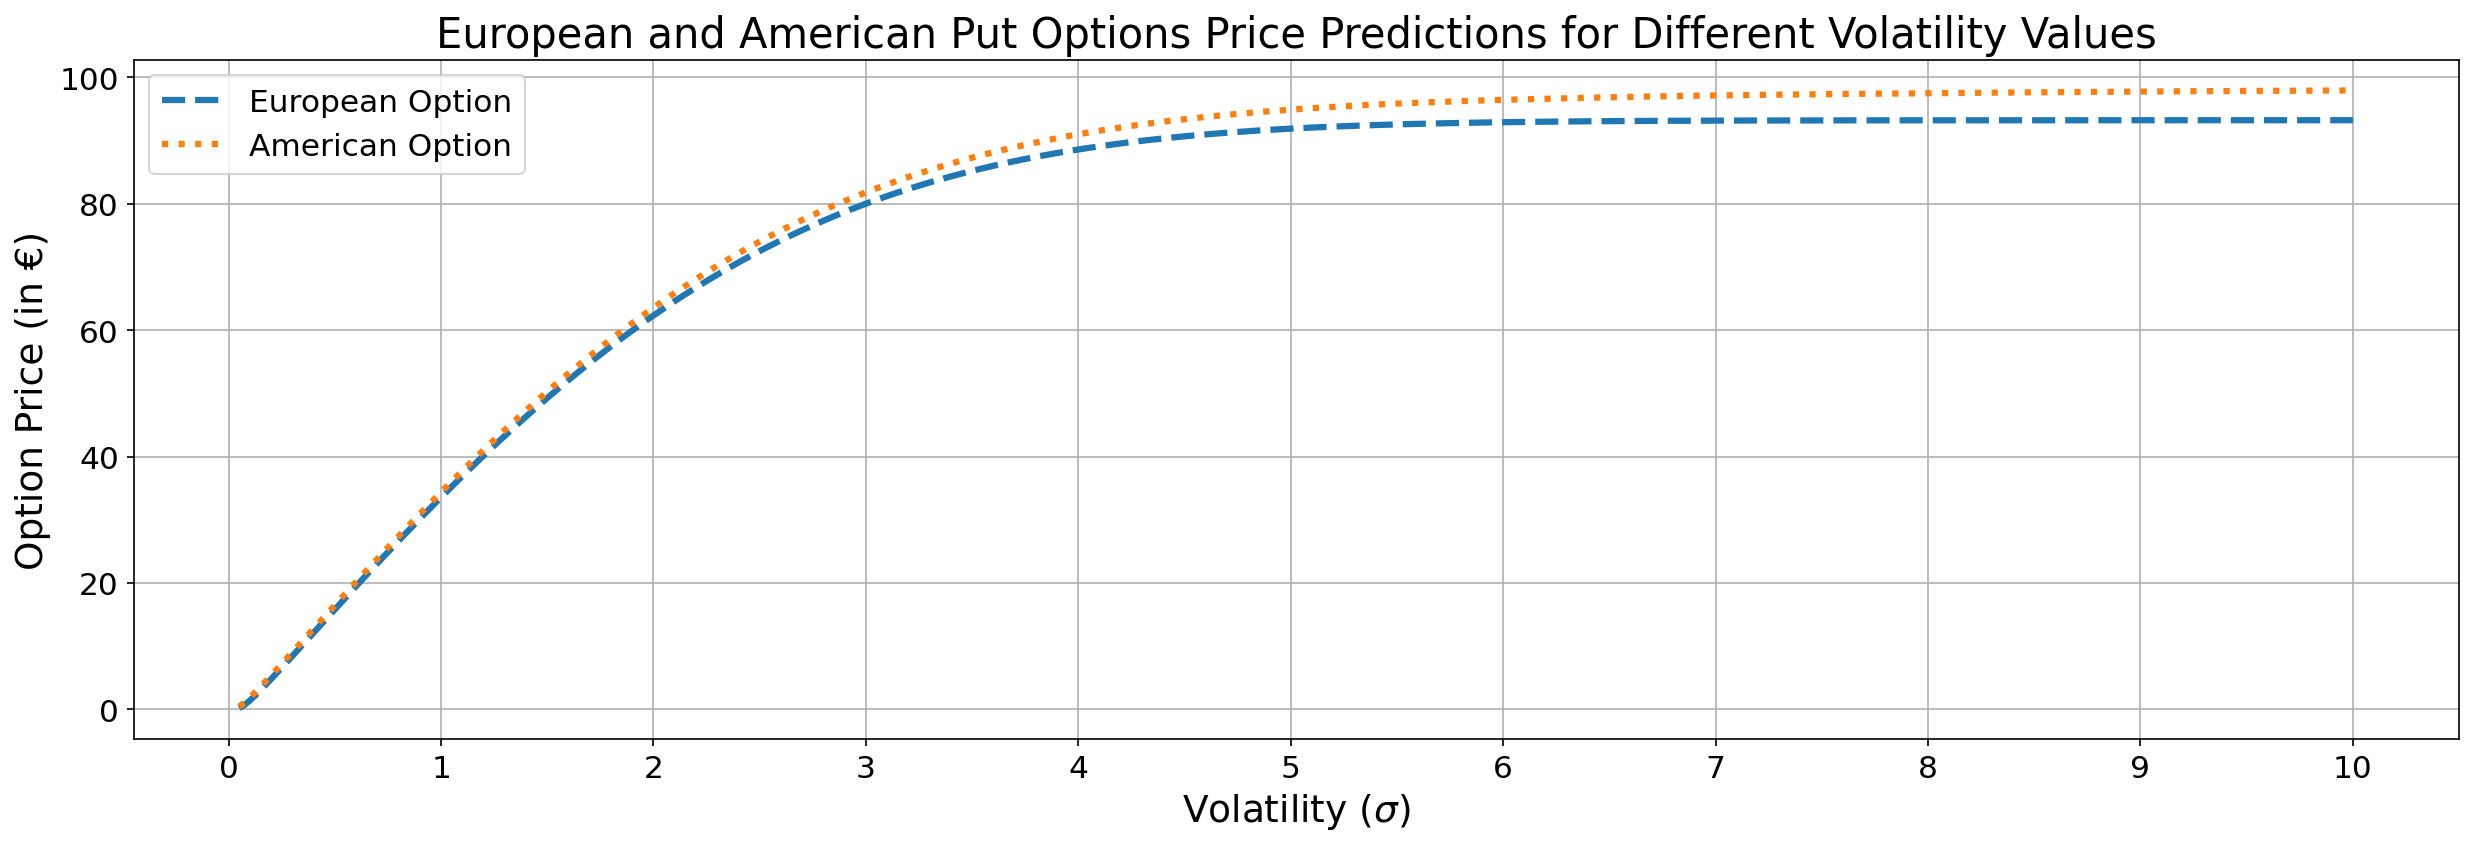

In [107]:
# Experimenting with different volatility values
S = 100
T = 1.
K = 99
r = 0.06
N = 50

Euro_call_prices = []; Amer_call_prices = []
Euro_put_prices = []; Amer_put_prices = []

vol = np.linspace(0.05, 10, num=399)
for sigma in vol:
#     Euro_call_price, delta = option_contract_bt(T, r, K, sigma, N, S, american=False)
#     Euro_call_prices.append(Euro_call_price)

#     Amer_call_price, delta = option_contract_bt(T, r , K, sigma, N, S, american=True)
#     Amer_call_prices.append(Amer_call_price)

    Euro_put_price, delta = option_contract_bt(T, r, K, sigma, N, S, type="P", american=False)
    Euro_put_prices.append(Euro_put_price)

    Amer_put_price, delta = option_contract_bt(T, r, K, sigma, N, S, type="P", american=True)
    Amer_put_prices.append(Amer_put_price)

# Make figure
plt.figure(figsize=(20,6), dpi=150)
plt.plot(vol, Euro_put_prices, linestyle="dashed", label="European Option", linewidth = 3)
plt.plot(vol, Amer_put_prices, linestyle="dotted", label="American Option", linewidth = 3)
plt.xlabel(r"Volatility ($\sigma$)", fontsize = 18)
plt.ylabel(r"Option Price (in €)", fontsize = 18)
plt.legend(fontsize = 15)
plt.title("European and American Put Options Price Predictions for Different Volatility Values", fontsize = 20)
plt.xticks(np.arange(0, 10.1, 1), fontsize = 15)
plt.yticks(fontsize = 15)
plt.grid()
plt.show()

------------------------------------------------------------------------------------------------------------------------------------
# Geometric Brownian Motion - Hedging Simulations

Consider again a short position in a European call option on a non-dividend-paying stock with a maturity of one year and strike price K of e99. Let the one year interest rate be 6% and the current price of the stock be e100. Furthermore, assume that the volatility is 20%.

In [146]:
""" Euler's Method """
def gbm_euler(S0, r, sigma, T, M):
    dt = T / M
    Sm = np.zeros((M+1, 2), dtype=float)   ;   Sm[0, 0] = S0
    for m in range(1, M+1):
        zm = norm.rvs(loc=0., scale=1)
        Sm[m, 0] = Sm[m-1, 0] + r*Sm[m-1, 0]*dt + sigma*Sm[m-1, 0]*sqrt(dt)*zm
        Sm[m, 1] = m * dt
    return Sm

<AxesSubplot:title={'center':'Simulated Geometric Brownian Motion'}, xlabel='Time', ylabel='Stock Price'>

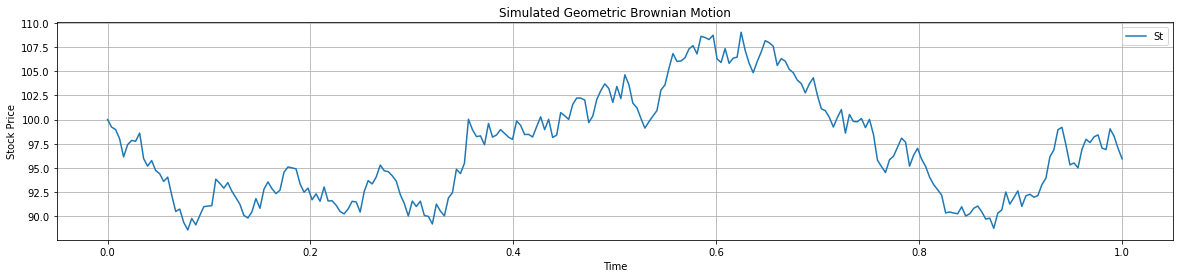

In [147]:
""" Geometric Brownian Motion - St Simulation"""
S0 = 100
sigma = .20
r = 0.06
T = 1.
M = 253
output = gbm_euler(S0, r, sigma, T, M)

temp_output = pd.DataFrame(output, columns=['St', 'Time'])
temp_output = temp_output.set_index('Time')
temp_output.plot(figsize=(20,4), grid=True, title="Simulated Geometric Brownian Motion", ylabel="Stock Price", label=f'Euler Method M={M}')

---------- Initial ---------- 
 V0 = 11.544690260826073 
 D0 = 0.6736807824006316 
 S0 = 100 
 Initial Balance = -55.82338797923708


>>> Re-balancing Frequency = WEEKLY
----------- Results ----------- 
 Option Payoff = 0 
 PnL = -50.11988838321941 


,Stock Price,Time,Delta,Payoff,Balance
0,100.000000,0.000000,0.673681,11.544690,-55.823388
1,99.225154,0.003953,0.673681,11.000549,-55.836628
2,98.969298,0.007905,0.673681,10.803420,-55.849872
3,98.018582,0.011858,0.673681,10.164958,-55.863118
4,96.144352,0.015810,0.673681,8.982069,-55.876368
...,...,...,...,...,...
249,96.901557,0.984190,0.373306,0.288716,-35.049388
250,99.041485,0.988142,0.525025,0.917264,-50.084243
251,98.278653,0.992095,0.525025,0.413633,-50.096122
252,97.016313,0.996047,0.525025,0.029261,-50.108004


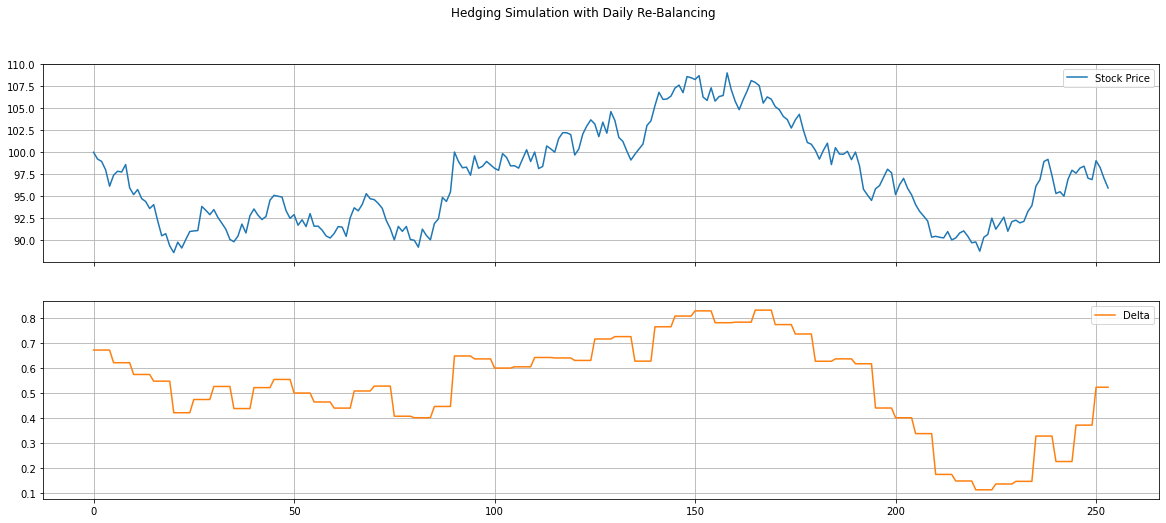

In [148]:
""" Option Parameters """
sigma = .20
r = 0.06
T = 1.
K = 99
V0, D0 = option_contract_bt(T, r , K, sigma, 1000, S0, type="C", american=False)
delta_hist = np.zeros((output.shape[0],3))  ;   dt = T/M

delta_hist[0, 0] = D0   ;   delta_hist[0, 1] =  V0  ;   delta_hist[0, 2] = V0 - D0 * S0     ;   Dt = D0
print(f'---------- Initial ---------- \n V0 = {V0} \n D0 = {D0} \n S0 = {S0} \n Initial Balance = {delta_hist[0, 2]}')

WEEKLY = 1   ;   print(f'\n\n>>> Re-balancing Frequency = {"WEEKLY" if WEEKLY else "DAILY"}')
for inx, st in enumerate(output[1:]):

    V_bt, D_bt = option_contract_bt(T-st[1], r , K, sigma, 1000, st[0], type="C", american=False)
    if WEEKLY:    Dt = D_bt if ((inx+1) % 5 == 0) else Dt
    else: Dt = D_bt

    """ Delta """
    delta_hist[inx+1,0] = Dt
    """ Payoff """
    delta_hist[inx+1, 1] = V_bt
    """ Balance """
    delta_hist[inx+1, 2] = delta_hist[inx, 2]*np.exp(r*dt)
    if WEEKLY:    delta_hist[inx+1, 2] += (delta_hist[inx,0] - Dt) * st[0] if ((inx+1) % 5 == 0) else 0
    else: delta_hist[inx+1, 2] += (delta_hist[inx,0] - Dt) * st[0]

if output[-1,0] >= K:
    """ (negative)Balance + Selling the stock - Call payoff """
    Payoff_T = output[-1,0] - K     ;   PnL = delta_hist[-1, 2] + output[-1,0]*delta_hist[-1, 1] - (output[-1,0] - K)
    print(f'----------- Results ----------- \n Option Payoff = {output[-1,0] - K} \n PnL = {PnL}')
else:
    """ Balance + Selling the stock """
    Payoff_T = 0     ;   PnL = delta_hist[-1, 2] + output[-1,0]*delta_hist[-1, 1]
    print(f'----------- Results ----------- \n Option Payoff = {0} \n PnL = {PnL} ')
result = np.append(output, np.array(delta_hist), axis=1)

""" Plotting """
# fig, ax_left = plt.subplots()
# ax_right = ax_left.twinx()

_results_df = pd.DataFrame(result, columns=['Stock Price', 'Time', 'Delta', 'Payoff', 'Balance'])
# _results_df.set_index('Time', inplace=True)

# _results_df[['Stock Price']].plot(figsize=(20,4), ax=ax_left, ylabel='Stock Price', legend=f'Euler Method M={M}',
#                               title='Hedging Simulation with Daily Re-Balancing', grid=True, logx=False)
# _results_df[['Delta']].plot(ax=ax_right, color='green', ylabel='Delta', legend='Delta', ylim=(-0.05, 1.05))
_results_df[['Stock Price','Delta']].plot(figsize=(20,8), subplots=True, title='Hedging Simulation with Daily Re-Balancing', grid=True)
_results_df #.plot(figsize=(20,12), subplots=True, title='Hedging Simulation with Daily Re-Balancing', grid=True)

In [303]:
100*np.exp(r*1)

106.18365465453596